# Appendix

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import patsy
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import tree
import seaborn as sns

In [12]:
sns.set(rc = {'figure.figsize': (12, 8)})
plt.style.use('fivethirtyeight')

### Read in the data and make necessary conversions

In [13]:
data = pd.read_csv("laptopData.csv", index_col=0)
data["ssd"] = data["ssd"].map({"SSD": 1, "No": 0})
data["BIN"] = data["BIN"].map({False: 0, True: 1})
data["sale"] = data["sale"].map({"SOLD": 1, "NOT SOLD": 0})
data

,sale,price,ghz,ram,hd,ssd,BIN
1,1,404.99,2.7,8.0,NaN,1,0
2,1,355.00,2.5,8.0,128.0,1,0
3,1,449.99,2.6,4.0,128.0,0,1
4,0,499.99,2.5,4.0,320.0,0,1
5,0,199.99,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...
216,1,480.00,NaN,6.0,128.0,1,1
217,1,452.00,2.6,8.0,240.0,1,0
218,1,358.00,2.6,4.0,128.0,0,0
219,1,450.00,NaN,4.0,128.0,1,0


### Exploratory analysis on the response variable

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

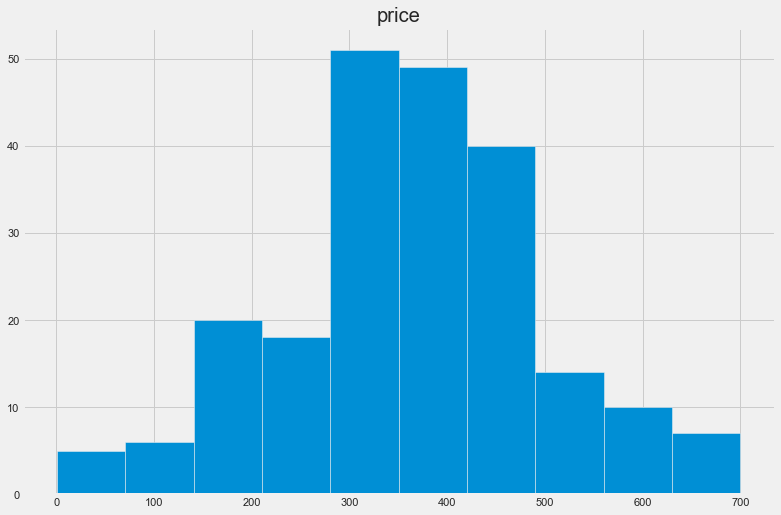

In [14]:
data.hist(column="price")

In [15]:
data["price"].describe()

count    220.000000
mean     364.162727
std      132.301459
min        1.000000
25%      299.980000
50%      357.500000
75%      449.992500
max      699.990000
Name: price, dtype: float64

Drop rows where the price is anomalous

In [16]:
data = data.drop(data[data["price"] < 10].index)

In [17]:
data.isna().sum()

sale      0
price     0
ghz      49
ram      42
hd       69
ssd       0
BIN       0
dtype: int64

### Data Imputation for missing values

In [18]:
data.corr().round(2)

,sale,price,ghz,ram,hd,ssd,BIN
sale,1.00,-0.12,0.10,-0.05,-0.05,0.16,-0.22
price,-0.12,1.00,0.28,0.25,-0.16,0.44,0.26
ghz,0.10,0.28,1.00,0.32,-0.08,0.19,-0.02
ram,-0.05,0.25,0.32,1.00,-0.02,0.29,-0.02
hd,-0.05,-0.16,-0.08,-0.02,1.00,-0.54,-0.17
ssd,0.16,0.44,0.19,0.29,-0.54,1.00,-0.01
BIN,-0.22,0.26,-0.02,-0.02,-0.17,-0.01,1.00


In [19]:
data[data["ssd"] == 1]["hd"].mode()

0    128.0
dtype: float64

In [20]:
data[data["ssd"] == 0]["hd"].mode()

0    320.0
dtype: float64

Fill in `hd` with most common (mode) value amongst laptops with same `ssd` value. This is because the highest correlated variable for `hd` is `ssd`

In [21]:
data["hd"].fillna(data["ssd"].map({1: 128, 0: 320}), inplace=True)
data.isna().sum()

sale      0
price     0
ghz      49
ram      42
hd        0
ssd       0
BIN       0
dtype: int64

Similarly, for `ghz` and `ram`, use a stratified mode to fill in missing values

In [22]:
data.groupby("ghz")["ram"].agg(pd.Series.mode)

ghz
2.5           4.0
2.6           4.0
2.7           8.0
2.8    [4.0, 8.0]
3.2           8.0
Name: ram, dtype: object

In [23]:
data.groupby("ram")["ghz"].agg(pd.Series.mode)

ram
2.0     2.5
3.0     2.5
4.0     2.5
6.0     2.6
8.0     2.5
12.0     []
16.0     []
Name: ghz, dtype: object

In [24]:
imputed_data_ram = data["ram"].fillna(data["ghz"].map({2.5: 4, 2.6: 4, 2.7: 8, 2.8: 4, 3.2: 8, np.nan: 4}))
imputed_data_ghz = data["ghz"].fillna(2.5) # most values are 2.5, so fill with this for simplicity
data["ram"] = imputed_data_ram
data["ghz"] = imputed_data_ghz
data.isna().sum()

sale     0
price    0
ghz      0
ram      0
hd       0
ssd      0
BIN      0
dtype: int64

### Model Selection & Variable Selection

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


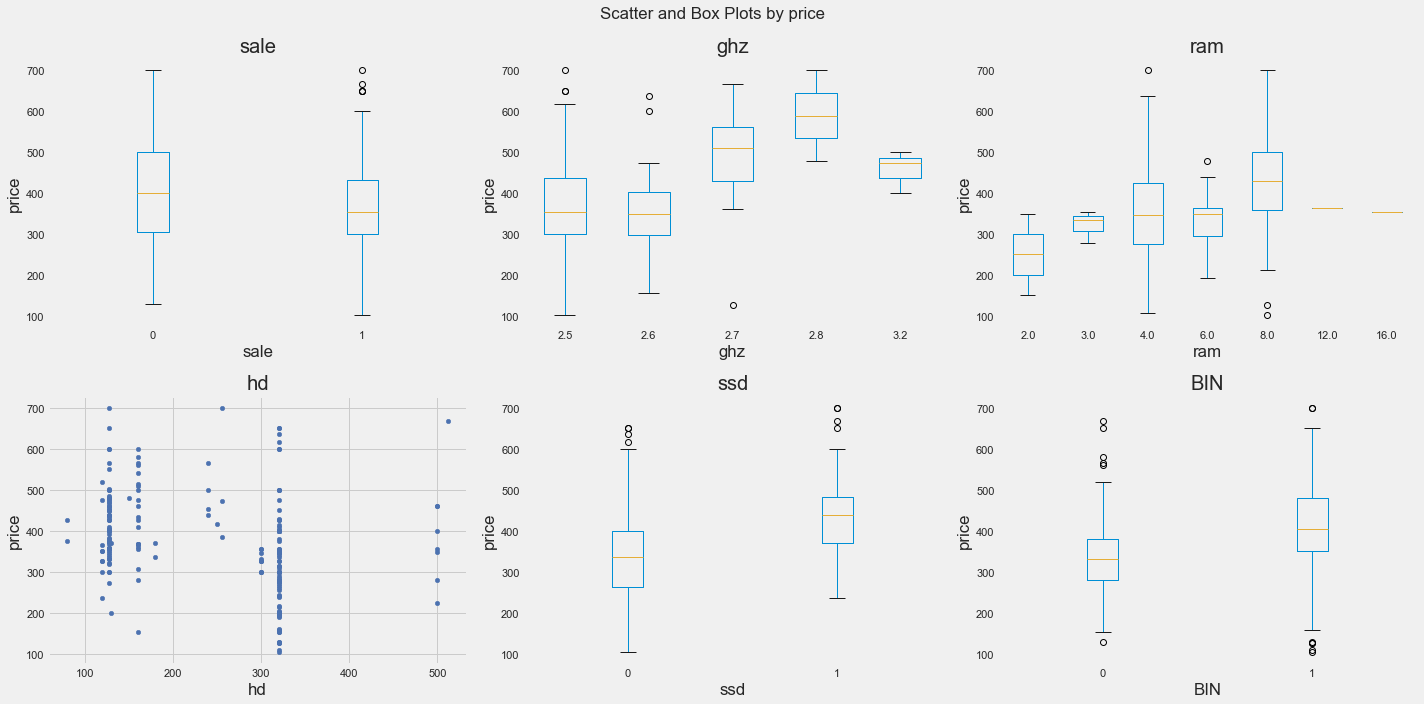

In [25]:
plt.rcParams["figure.figsize"] = (20,10)
def draw_outcome_plots(df, outcome, n_rows, n_cols):
    fig=plt.figure()
    variables = df.columns.drop(outcome)
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        if len(df[var_name].unique()) > 10:
            df.plot.scatter(x= var_name, y= outcome, ax=ax)
        else:
            df.boxplot(column=outcome, by=var_name, grid = False, ax=ax)
        ax.set(ylabel=outcome)
        ax.set_title(var_name)
    fig.suptitle('Scatter and Box Plots by '+outcome)
    fig.tight_layout()
    plt.show()
draw_outcome_plots(data, 'price', 2, 3)

Looking at boxplots, there seem to be linear trends across all variables except `sale` and `hd`. This may need further investigation.

This is indicative of a linear regression model, also because the response variable is normally distributed.

Exclude `sale` since that is being influenced by the response variable

In [26]:
y1, X1 = patsy.dmatrices("price ~ ghz + ram + hd + ssd + BIN", data, return_type="dataframe")
model1 = sm.OLS(y1, X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     18.95
Date:                Thu, 08 Sep 2022   Prob (F-statistic):           1.58e-15
Time:                        15:33:47   Log-Likelihood:                -1296.4
No. Observations:                 215   AIC:                             2605.
Df Residuals:                     209   BIC:                             2625.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -183.0675    178.151     -1.028      0.3

Also check with an interaction term of `hd:ssd` since that is an inference we are interested in

In [27]:
y2, X2 = patsy.dmatrices("price ~ ghz + ram + hd*ssd + BIN", data, return_type="dataframe")
model2 = sm.OLS(y2, X2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     17.96
Date:                Thu, 08 Sep 2022   Prob (F-statistic):           9.41e-17
Time:                        15:33:47   Log-Likelihood:                -1291.7
No. Observations:                 215   AIC:                             2597.
Df Residuals:                     208   BIC:                             2621.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.7613    182.228     -0.141      0.8

AIC values are very similar, so prefer to keep the model without the interaction term as it is more easily interpretable, and the coefficients seem more reasonable and closer to reality

### Model Diagnostics

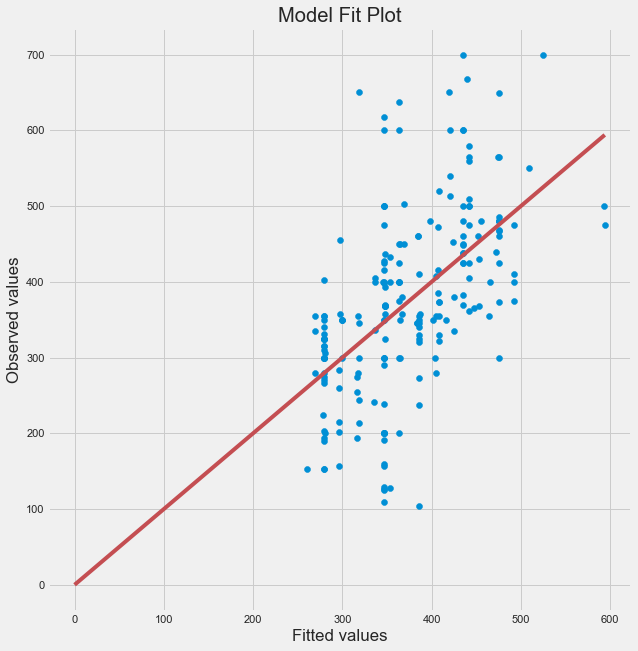

In [44]:
def diagnostic_plots(fit, response):
    fig, (ax1) = plt.subplots(1,1)
    ax1.scatter(fit.fittedvalues, response)
    abline_max = min(max(fit.fittedvalues), max(response))
    ax1.plot([0, abline_max], [0, abline_max], color='r')
    ax1.set_title('Model Fit Plot')
    ax1.set_ylabel('Observed values')
    ax1.set_xlabel('Fitted values');
    ax1.set_box_aspect(1)
    
diagnostic_plots(model1, data.price)

### Recommendation

From the best model, predict prices and look at laptops that have lower prices than the predictions. These are "good" deals. Further filter based on requirements like `ssd=1`, and `BIN=0` (since this makes the price cheaper) and large HD capacity

In [36]:
data["savings"] =  data["price"] - model1.predict(X1)
data[(model1.predict(X1) < data["price"]) & (data["ssd"] == 1)  & (data["sale"] == 0) ]

,sale,price,ghz,ram,hd,ssd,BIN,savings
6,0,699.95,2.5,4.0,128.0,1,1,264.285959
7,0,437.71,2.5,4.0,128.0,1,1,2.045959
23,0,565.00,2.5,8.0,240.0,1,1,90.639956
30,0,500.00,2.7,8.0,160.0,1,0,58.356284
36,0,437.71,2.5,4.0,128.0,1,1,2.045959
39,0,499.99,2.7,8.0,128.0,1,0,58.186608
53,0,564.95,2.5,8.0,128.0,1,1,90.031090
54,0,560.00,2.7,8.0,160.0,1,0,118.356284
75,0,565.00,2.7,8.0,160.0,1,0,123.356284
100,0,579.00,2.7,8.0,160.0,1,0,137.356284


In [37]:
data.loc[[23, 30, 53, 100]]

,sale,price,ghz,ram,hd,ssd,BIN,savings
23,0,565.00,2.5,8.0,240.0,1,1,90.639956
30,0,500.00,2.7,8.0,160.0,1,0,58.356284
53,0,564.95,2.5,8.0,128.0,1,1,90.031090
100,0,579.00,2.7,8.0,160.0,1,0,137.356284
